In [2]:
setwd("/home/pasoneto/Documents/github/doc_suomi/code")
source("utils.R")
setwd("/home/pasoneto/Documents/github/doc_suomi/data")

# Descriptives

## Segmentation strategy

Descriptives of features $f$ were calculated by collapsing each album in 4 segments. The number of tracks within each each segment is equal to the nearest integer to $\frac{length\ of\ album}{4}$. 

The size of the last segment is determined according to the following:

- If we round up, last chunk is smaller;
- If we round down, last chunk larger;
- If $\frac{length\ of\ album}{4} = x.5$, section length is rounded up, which leaves section 4 smaller.

Note: after averaging features across sections, each album contributes exactly with 4 observation for each feature (one for each section). The distribution of tracks throughout segments is: 

- 1st	12652
- 2nd	12652
- 3d 	12652
- 4th	10129

In [121]:
dt = fread("novo.csv") 
dt %>% select(!V1) %>% group_by(album_id) %>%
       mutate(album_length = NROW(track_number)) %>%
       filter(album_length %in% c(6:16)) %>%
       mutate(position = segment2(track_number)) %>% ungroup() %>%
       group_by(position) %>% 
       summarise(tracks = NROW(track_number))

`summarise()` ungrouping output (override with `.groups` argument)



position,tracks
<chr>,<int>
1st,12652
2nd,12652
3d,12652
4th,10129


## Metric

For each feature and each one of the 4 sections, I computed the average feature $f$ throughout all tracks $Tn$, and then took an overall average for each album $k$:

\begin{equation}
    \frac{1}{kTn}\sum\limits^k_{j = 1}\sum\limits^{Tn}_{i = 1}f_{ji}
\end{equation}

Features were converted to z-scores within each album, so the results are expressed in terms of SDs.

In [123]:
dt = fread("novo.csv") 

dt %<>%
    select(!V1) %>%
    group_by(album_id) %>% mutate(album_length = NROW(track_number)) %>% 
    filter(album_length < 17) %>% filter(album_length > 5) %>% ungroup() %>%
    group_by(album_id) %>% mutate(posicao_track = segment2(track_number)) %>% group_by(album_id, posicao_track) %>%
    mutate(contributor_tracks = NROW(posicao_track)) %>% 
    ungroup() %>% select(posicao_track, contributor_tracks, valence, energy, album_id, loudness, tempo) %>%
    group_by(posicao_track, album_id) %>% 
    summarise(valence = mean(valence), energy = mean(energy), loudness = mean(loudness), 
              tempo = mean(tempo), n_tracks = unique(contributor_tracks)); 

`summarise()` regrouping output by 'posicao_track' (override with `.groups` argument)



In [124]:
dt %<>%
    select(album_id, posicao_track, valence, energy, loudness, tempo) %>%
    group_by(album_id) %>%
    mutate(valence = z_transf(valence) , energy = z_transf(energy), loudness = z_transf(loudness), 
           tempo = z_transf(tempo)) %>%
    melt(id.measures = c("loudness", "energy", "tempo", "valence")) %>%
    group_by(posicao_track, album_id, variable) %>%
    summarize(f_value = mean(value)) %>%
    
    ungroup() %>% group_by(posicao_track, variable) %>%

    summarize(value = mean(f_value), se = sd(f_value)/sqrt(NROW(f_value))); head(dt)

Using album_id, posicao_track as id variables

`summarise()` regrouping output by 'posicao_track', 'album_id' (override with `.groups` argument)

`summarise()` regrouping output by 'posicao_track' (override with `.groups` argument)



posicao_track,variable,value,se
<chr>,<fct>,<dbl>,<dbl>
1st,valence,0.144926374,0.01305378
1st,energy,0.212589099,0.01288493
1st,loudness,0.187624019,0.01312372
1st,tempo,0.041165508,0.01324102
2nd,valence,0.043243236,0.01301546
2nd,energy,0.005200893,0.01298991


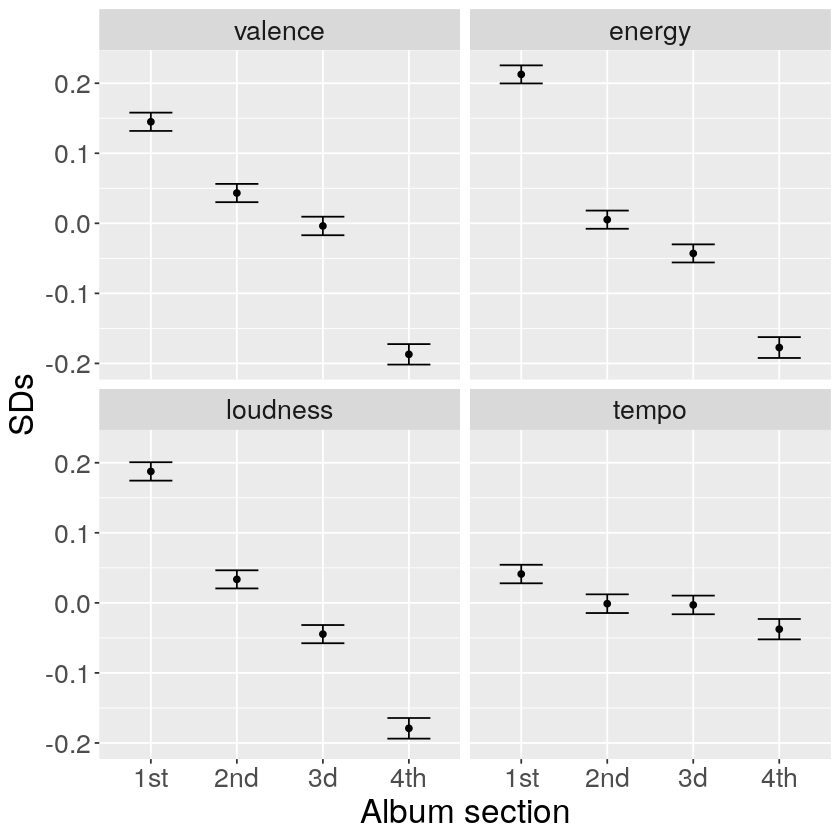

In [120]:
dt %>% ggplot(aes(x = posicao_track, y = value)) + 
            facet_wrap(~variable)+ xlim("1st","2nd", "3d", "4th")+ geom_point()+
            geom_errorbar(aes(ymin=value-se, ymax=value+se), width = .5) +
            theme(text = element_text(size = 20)) + xlab("Album section") + ylab("SDs")

# Dissimilarity matrix

Dissimilarities were computed between all pairwise combinations of tracks $(A, B)$ within the same album, and summed across all features $f$. Then the dissimilarities were averaged across all albums $k$:

\begin{equation}\label{eq:um}
 d(A, B) = \frac{1}{k}\sum\limits_{j = 1}^{k}\sqrt{\sum \limits_{i = 1}^{f} (A_{ji}-B_{ji})^2 }
\end{equation}

The output of $d(A, B)$ constitutes the mean dissimilarity between two tracks in positions $A$ and $B$.

## Sanity check

Dissimilarity measurements were taken 1) from the original dataset, and 2) from a shuffled version of the data, where track numbers were randomly shuffled within each ablum. I did this because:

If the pattern of dissimilarities found in the original dataset is really due track ordering factors, these patterns should disapear in a shuffled version of albums. 

In [8]:
dt = fread("novo.csv")
dt %<>% select(!V1)
dt %<>% group_by(album_id) %>% mutate(album_length = NROW(track_number)) %>%
        filter(album_length < 17) %>% filter(album_length > 5) %>%
        select(track_number, album_id, valence, energy, loudness, tempo)

dt %<>% group_by(album_id) %>%
        select(album_id, track_number, valence, energy, loudness, tempo) %>%
        mutate(valence = z_transf(valence) , energy = z_transf(energy), 
               loudness = z_transf(loudness), tempo = z_transf(tempo) ) %>%
        group_by(track_number, album_id) %>%
        arrange(album_id) %>% ungroup()

dt <- split(dt, dt$album_id)
for(i in 1:length(dt)) { 
    dt[[i]] = tidyr::pivot_wider(dt[[i]], 
                                 names_from = album_id, 
                                 values_from = c(valence, energy, loudness, tempo))
    #padding to 16
    dt[[i]] <- dt[[i]][1:16,]
    #rebuilding track number
    dt[[i]]$track_number[1:nrow(dt[[i]])] = 1:nrow(dt[[i]])
    #removing track number and calculating dissimilarity for each album
    dt[[i]] <- as.matrix(daisy(dt[[i]][2:5]))
    dt[[i]][dt[[i]] == 0] <- NA
                }

dt <- apply(simplify2array(dt), 1:2, function(x){mean(x, na.rm = TRUE)})
redblack = colorRampPalette(c("red", "black"))(100)

# ############## Random
r = fread("novo.csv")
r %<>% select(!V1)
r %<>% 
    group_by(album_id) %>% mutate(album_length = NROW(track_number)) %>%
    filter(album_length < 17) %>% filter(album_length > 5) %>%
    mutate(valence = sample(valence, length(valence)), 
           energy = sample(energy, length(energy)),
           loudness = sample(loudness, length(loudness)),
           tempo = sample(tempo, length(tempo)))

r %<>% group_by(album_id) %>%
        select(album_id, track_number, valence, energy, loudness, tempo) %>%
        mutate(valence = z_transf(valence) , energy = z_transf(energy), 
               loudness = z_transf(loudness), tempo = z_transf(tempo) ) %>%
        group_by(track_number, album_id) %>%
        arrange(album_id) %>% ungroup()

r <- split(r, r$album_id)
for(i in 1:length(r)) { 
    r[[i]] = tidyr::pivot_wider(r[[i]], 
                                names_from = album_id, 
                                values_from = c(valence, energy, loudness, tempo))
    #taking off column 1 (track_number) and gettin matrix
    r[[i]] <- r[[i]][1:16,]
    r[[i]]$track_number[1:nrow(r[[i]])] = 1:nrow(r[[i]])
    r[[i]] <- as.matrix(daisy(r[[i]][2:ncol(r[[i]])]))
    r[[i]][r[[i]] == 0] <- NA
                       }
r <- apply(simplify2array(r), 1:2, function(x){mean(x, na.rm = TRUE)})
redblack = colorRampPalette(c("red", "black"))(100)

## Results - Original dataset

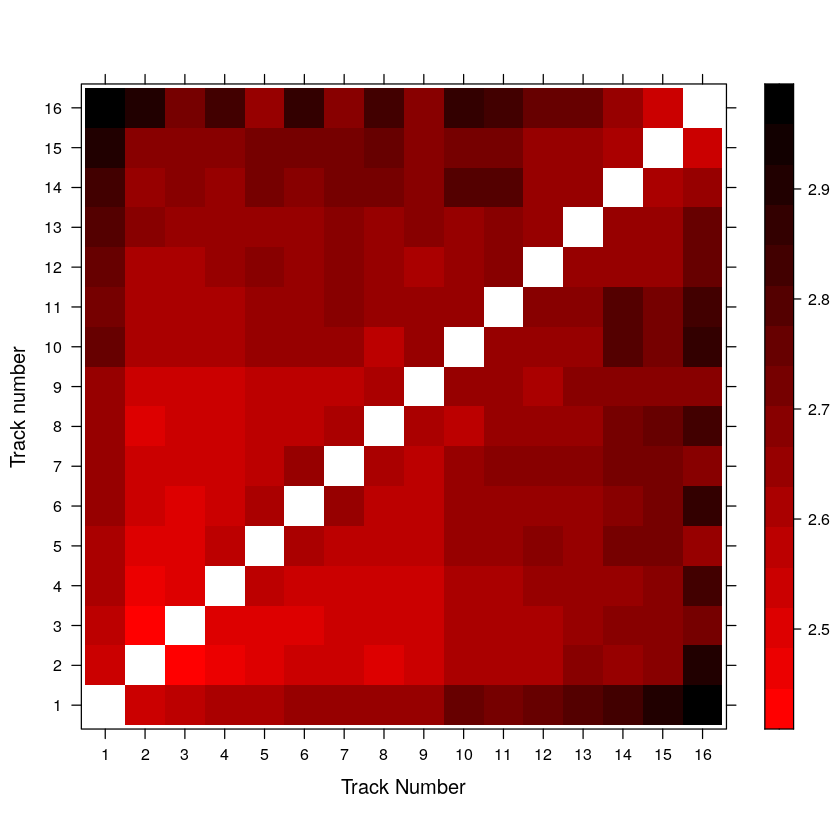

In [9]:
levelplot(dt, col.regions = redblack, xlab = "Track Number", ylab = "Track number")

## Results - Shuffled dataset

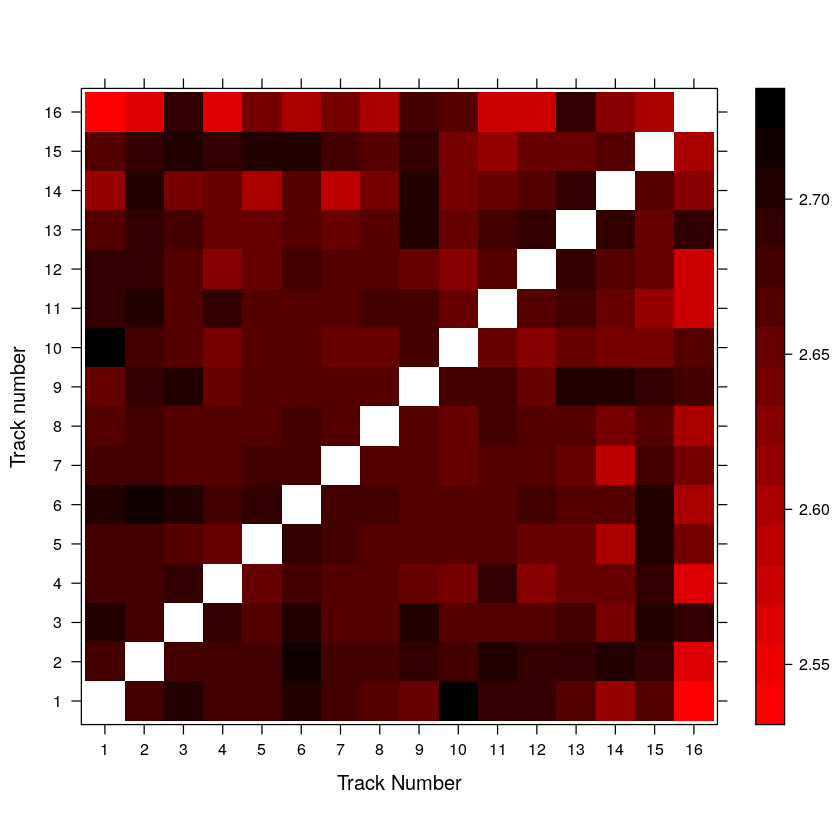

In [10]:
levelplot(r, col.regions = redblack, xlab = "Track Number", ylab = "Track number")

In [ ]:
# Visual inspection
# for(i in 1:length(dt)){
#         print(levelplot(dt[[i]], col.regions= redblack, xlab = "Track Number", ylab = "Track number"))
#         print(paste("album", i))
# }

In [94]:
dt = fread("novo.csv")

dt %<>% 
    select(!V1) %>%
    group_by(album_id) %>% mutate(album_length = NROW(track_number)) %>%
    filter(album_length < 17) %>% filter(album_length > 5)

dt %<>% group_by(album_id) %>%
        mutate(posicao_track = segment2(track_number)) %>% 
        ungroup() %>%
        select(posicao_track, valence, energy, album_id, loudness, tempo) %>%
        group_by(posicao_track, album_id) %>%
        summarize(valence = mean(valence), energy = mean(energy), 
               loudness = mean(loudness), tempo = mean(tempo)) %>%
        arrange(album_id) %>%

        select(valence, energy, loudness, tempo, album_id, posicao_track) %>%
        group_by(album_id) %>%
        ungroup() %>%
        tidyr::pivot_wider(names_from = album_id, values_from = c(valence, energy, loudness, tempo)) %>%
        select(!posicao_track) %>%
        daisy() %>% as.matrix()

dt[dt == 0] <- NA
redblack = colorRampPalette(c("red", "black"))(100)

`summarise()` regrouping output by 'posicao_track' (override with `.groups` argument)



# Dissimilarity by album segment

Next we collapsed - again - each album in 4 different segments see [segmentation strategy](#Descriptives). Then we computed the average feature for each album section. Dissimilarity measurements were taken using [Eq. 1](#Dissimilarity-matrix), but with the tuple $(A, B)$ meaning all pairwise combinations of album sections, instead of album tracks.

Note: even though section 4 is constituted of fewer tracks, this does not affect - directly - the computation of dissimilarity ratings.

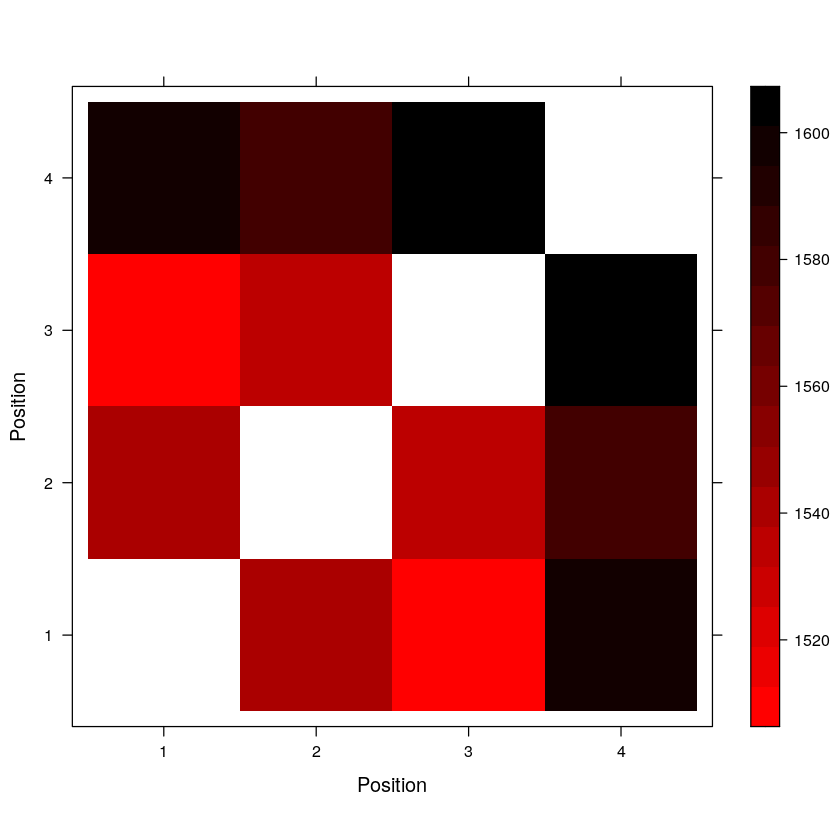

In [95]:
#Dissimilarity by section
dt %>% levelplot(xlab = "Position", ylab = "Position", 
                 col.regions=redblack)

In [99]:
dt = fread("novo.csv"); 
dt %<>% select(!V1)
dt %<>% group_by(album_id) %>%
        mutate(album_length = NROW(track_number)) %>%
        filter(album_length < 17) %>% 
        filter(album_length > 5); 

dt %<>% group_by(album_id) %>%
        mutate(posicao_track = segment2(track_number), valence = z_transf(valence), 
               energy = z_transf(energy), loudness = z_transf(loudness), tempo = z_transf(tempo)) %>%
        ungroup() %>% 
        select(posicao_track, valence, energy, album_id, loudness, tempo) %>% 
        group_by(posicao_track, album_id) %>% 
        summarize(valence = mean(valence), energy = mean(energy),
                  loudness = mean(loudness), tempo = mean(tempo)) %>%
        arrange(album_id)

`summarise()` regrouping output by 'posicao_track' (override with `.groups` argument)



# Upsampling

Each album has a certain length, and this might affect some of the descriptive statistics that we are computing.

In order to normalize the length of each album, we can duplicate each track $\frac{n}{Al}$ times, where $n$ is the Least Common Multiplier $LCM$ of all album lengths $Al$.

## Problem

We have $Al$ from 5 to 17. The $LCM$ of this array is 720720, which will result in a total of 3 billion lines of data. I tried processing it, but I don't have enough memory.

## Alternative

We can exclude some albums in order to minimize LCM, while also minimizing the loss of albums from our dataset. This was implemented and shown below.

## Procedure

- I created subsets $S$ of 2 to 11 different $Al$s. For instance, two subsets of $Al$s could be $S_2 = \{6, 7\}$ or $S_3 = \{6, 8, 9\}$, where each element within the set represents an $Al$, and the subscript to $S$ means the number of $Al$ within the subset.


- From $S_2$ to $S_{11}$, I tested all possible subset of $Al$s and calculated LCM for each combination. For instance, $LCM(\{6, 7\}) = 42$ and $LCM(\{6, 8, 9\}) = 72$.


- Then, for each subset of $Al$s, I kept only the combination which yealded the lowest LCM. For instance, if $S_3= \{6, 7, 10\}$ and $S_3' = \{6, 8, 10\}$, I kept only the $S_3$.


- I visually chose a cut off to maximize the number of albuns within the dataset, while minimizing the $LCM$.

In [125]:
j = fread("grande_sem_low.csv"); 

j %<>% group_by(album_id) %>%
        mutate(album_length = NROW(track_number)) %>%
        filter(album_length < 17) %>% 
        filter(album_length > 5)

## Result

Table and graph of LCM (y axis) by number of remaining tracks (x axis).

In [126]:
group <- c(); n_groups <- c(); lcm <- c(); size <- c()
for(i in 2:11){
    n_groups <- c(n_groups, i)
    mt   <- combn(unique(j$album_length), i) # every combination
    lcms <- apply(mt, 2, LCM) # get LCMs for each combination
    winner <- mt[, which(lcms == min(lcms))] # album sizes of lowest LCM
    group[[i-1]] <- paste("album ", winner) # group with lowest lcm
    lcm <- c(lcm, min(lcms)) # lcm of winner
    size <- c(size, nrow(filter(j, album_length %in% winner)))
}; tibble("LCMs" = lcm, "Size of dataset after cut" = size)

LCMs,Size of dataset after cut
<int>,<int>
12,8958
24,11190
48,17174
120,22670
240,28654
720,30661
1680,38321
5040,40328
55440,46433


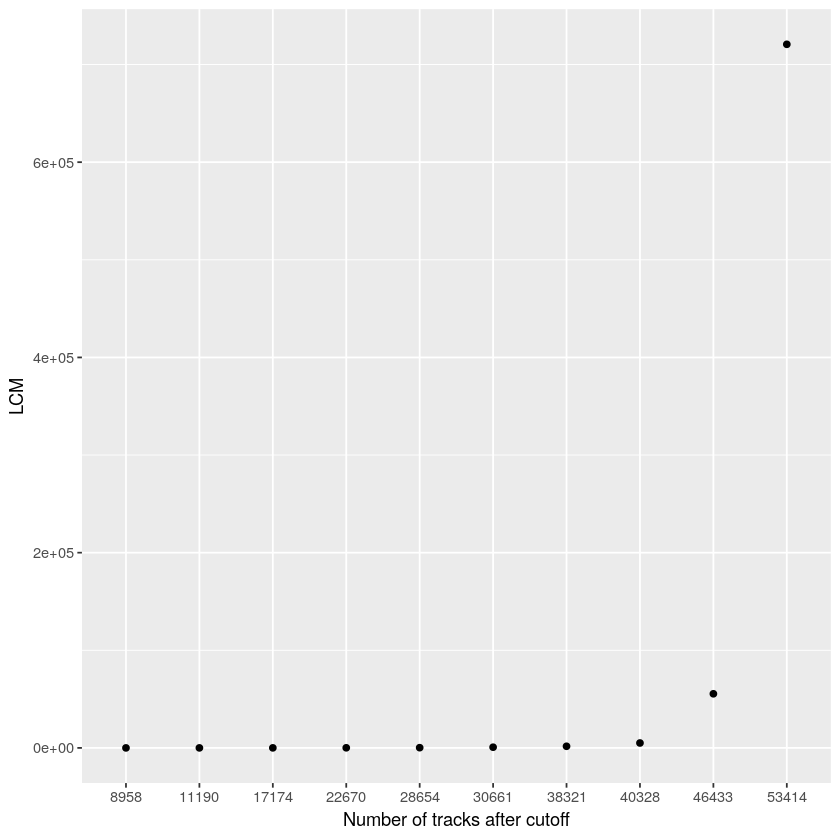

In [128]:
data.frame(x = size, y = lcm) %>% 
    ggplot(aes(x = as.factor(x), y = y), group = 1) +
    geom_point() + xlab("Number of tracks after cutoff") + ylab("LCM");

## Conclusion

If we keep albums of size 6, 7, 8, 9, 10, 12, 14, 15 and 16, we decrease LCM to 5040 (third point from right to left on the x axis), and the number of tracks in our data to 36636. We loose around 12 thousand tracks, but our dataset decreases from 3 billion to 25 million datapoints.

Next I'm implementing the upsampling by the factor of 5040

In [129]:
setwd("/home/pasoneto/Documents/Ciência/Estudo Computacional/")
j = fread("grande_sem_low.csv")

up_sample <- function(data){
                lcm <- 5040
                n_rep = lcm/nrow(data)
                data = data.frame(data[rep(1:nrow(data), n_rep), ])
                return(data)
            }

j %<>%
    select(track_number, album_id, valence, energy, loudness, tempo) %>%
    group_by(album_id) %>%
    mutate(t = max(track_number)) %>%
    filter(t > 4) %>% filter(t<17) %>%
    filter(t %in% c(6, 7, 8, 9, 10, 12, 14, 15, 16)) %>%
    #album with wrong number of tracks
    filter(album_id != "6tdH8iZTmiYgBcd2KAjnCV") %>% ungroup()

j = split(j, j$album_id)

for(i in 1:length(j)){
    j[[i]] = up_sample(j[[i]])
}

j = bind_rows(j)
#Verification
#nrow(j) == 3099*5040

# Remaking the heatmaps


In [4]:
j %<>% group_by(album_id) %>%
      select(album_id, track_number, valence, energy, loudness, tempo) %>%
      mutate(valence = z_transf(valence) , energy = z_transf(energy), 
             loudness = z_transf(loudness), tempo = z_transf(tempo) ) %>%
      group_by(album_id) %>%
      arrange(track_number) %>% ungroup() %>%
      select(valence, energy, loudness, tempo, track_number, album_id)

j %<>%
    group_by(album_id) %>%
    select(!track_number) %>%
    mutate(row = row_number()) %>% ungroup() %>%
    tidyr::pivot_wider(names_from = album_id, values_from = c(valence, energy, loudness, tempo)) %>%
    select(!row) %>%
    daisy() %>% as.matrix()

j[j == 0] <- NA
redblack = colorRampPalette(c("red", "black"))(100)

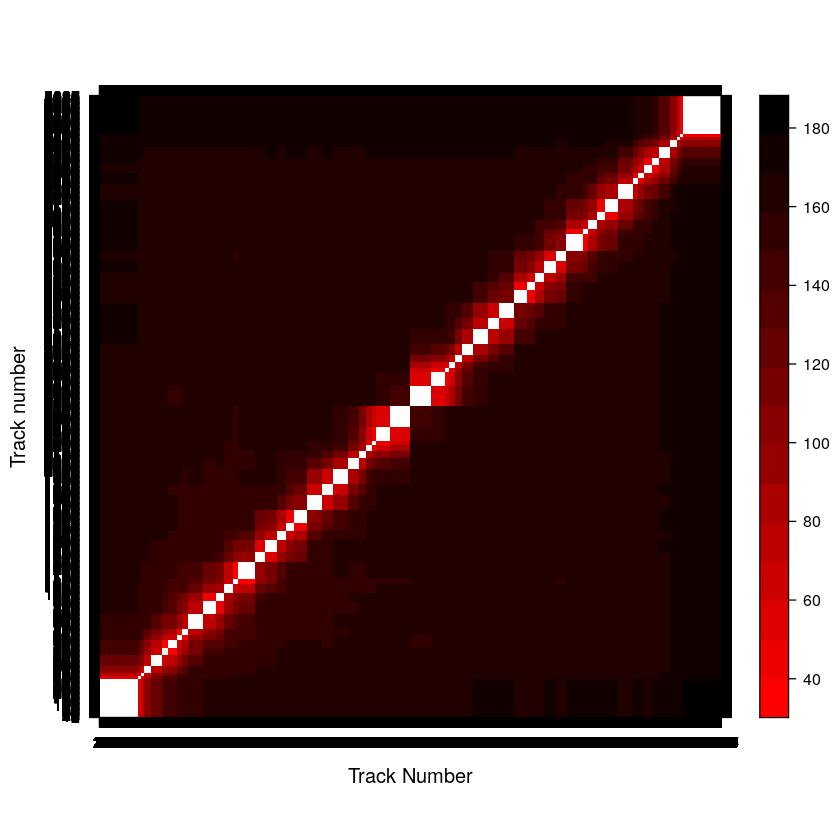

In [14]:
j %>% 
    as.matrix() %>%
    levelplot(col.regions= redblack, xlab = "Track Number", ylab = "Track number")